# Preprocessing: 

**Summary**
This notebook includes the preprocessing for both iterations. It is worth noting that some analysis included in the second iteration could be considered part of an exploratory data analysis.

Following the structure of previous notebooks, the second iteration will appear first, as it is the most relevant one.

The features were chosen to strike a balance between expected outcomes - average earnings per seller, and exploratory insights for future learning, such as seller focus on new or existing products.

The target variable, a binary column defined as 0 (not churn) for the sellers with >= 1 order for the last month of data was imbalanced, with 82% churn (1) and 18% not churn. 

Variables were modified, including logistic transformation to normalize the seller earnings distribution, one-hot encoding for the seller creation time of month or converting seller creation date to days since seller creation, among other operations. These modifications derived from insights of the first iteration.

------
**Table of contents**

1. Preprocessing:
    1. Analysis of the distributions
    2. New features included
    3. Initial columns dropped
2. Correlations
3. Backup: Iteration 1
    1. Baseline Model
    2. New features created
    3. Data distribution
    4. Splitting and Scaling

------

### Libraries:

In [1]:
#Imports:
#General imports
import numpy as np
import pandas as pd
import re
import datetime


# Plotting
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objs as go
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.tree import plot_tree

In [2]:
#Imports:
#Sklearn
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectPercentile, f_regression
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import Ridge
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

#Sklearn metrics
from sklearn.metrics import RocCurveDisplay, roc_curve, roc_auc_score, recall_score, precision_score, f1_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay




In [3]:
# SMOTE
from imblearn.over_sampling import SMOTE

### Functions:

In [4]:
def num_col_dist(cols_list, df):
    """
    Plot the distributions of numerical columns in a DataFrame.

    Parameters:
        cols_list (list): A list of column names to plot the distributions.
        df (DataFrame): The DataFrame containing the numerical columns.
    """
    for col in cols_list:
        plt.figure()
        sns.histplot(data=df, x=col, bins=25, color="#80a2ff")
        plt.axvline(df[col].mean(), color='r', linestyle='--', label='Mean')
        plt.axvline(df[col].median(), color='g', linestyle='--', label='Median')
        plt.xlabel(col)
        plt.title(col)
        plt.legend()
        plt.show()

## Iteration 2: Preprocessing

* Log transformation +1 was applied to avg_effective_delivery_days and avg_effective_earnings
* Month of seller creation and days since seller creation were included as features, based on findings of the first iteration
* Multiple columns were dropped to address multicollinearity, yet it is still present, this should be taken into account for the modelling

**Additionall business related findings**

* Using the average effective earnings as a KPI could be misleading since it does not follow a normal distribution, so the average does not represent the majority of sellers.
* Over time, the company has had fewer active sellers (sellers with at least one effective order).

In [5]:
#Uploading the file:
df02sellers = pd.read_csv("../data/elenas-it2-postwrangling.csv", index_col="seller_id")

#Preview:
df02sellers.head(5)

,Unnamed: 0,seller_created_at,total_orders,effective_ratio,rto_ratio,return_ratio,cancelled_ratio,departments_sold,number_of_clients,avg_effective_delivery_days,...,avg_cart_items,avg_vendor_discount,number_of_products,number_of_categories,average_prod_existence_days,total_products_shared,number_of_vouchers,number_of_credits,number_of_used_credits,avg_credit_amount
seller_id,,,,,,,,,,,,,,,,,,,,,
11415920,0,2022-09-30,1,1.00,0.00,0.00,0.00,1,1,2.00,...,1.0,0.0,1,1,565.0,0,36,19,0,7526.315789
11415923,1,2022-09-30,70,0.69,0.14,0.01,0.16,4,47,6.73,...,1.0,6418.0,46,16,457.0,112,136,23,1,7434.782609
11415930,2,2022-09-30,2,1.00,0.00,0.00,0.00,1,1,10.00,...,1.0,0.0,2,2,618.0,67,80,35,0,7400.000000
11415933,3,2022-09-30,7,0.43,0.29,0.00,0.29,1,1,3.33,...,1.0,4457.0,7,5,613.0,7,44,17,1,9058.823529
11415940,4,2022-09-30,2,0.50,0.00,0.00,0.50,2,2,9.00,...,1.0,0.0,2,2,310.0,4,45,17,0,7176.470588


In [6]:
#Reviewing the clumns
print(df02sellers.columns)

Index(['Unnamed: 0', 'seller_created_at', 'total_orders', 'effective_ratio',
       'rto_ratio', 'return_ratio', 'cancelled_ratio', 'departments_sold',
       'number_of_clients', 'avg_effective_delivery_days',
       'total_effective_earnings', 'avg_effective_earnings',
       'avg_client_price', 'avg_shipment_cost', 'total_discount',
       'effective_orders_november', 'effective_orders_december',
       'effective_orders_january', 'effective_orders_february', 'churn',
       'is_referred', 'avg_cart_items', 'avg_vendor_discount',
       'number_of_products', 'number_of_categories',
       'average_prod_existence_days', 'total_products_shared',
       'number_of_vouchers', 'number_of_credits', 'number_of_used_credits',
       'avg_credit_amount'],
      dtype='object')


In [7]:
#Removing Unnamed
df02sellers.drop('Unnamed: 0', axis=1, inplace=True)

### Correlations & new features

* To address multicollinearity, I will drop the number of products, total orders, and return ratio 

* The monthly number of orders (October, November, December, etc) take multicollinearity into account since there is no monthly number of orders for March

* "Month of seller creation" and "days since seller creation" are new columns based on the conclusions of the first iteration

* Over time, Elenas has had fewer active sellers (sellers with at least one effective order)

In [8]:
df02sellers2 = df02sellers.drop(["total_discount", "is_referred", "avg_cart_items"], axis=1)

/var/folders/27/tbf7s19s47137sfh7rlj9pvh0000gn/T/ipykernel_4042/614520354.py:4: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr = df02sellers2.corr().round(2)


Text(0.5, 1.0, 'Correlation matrix')

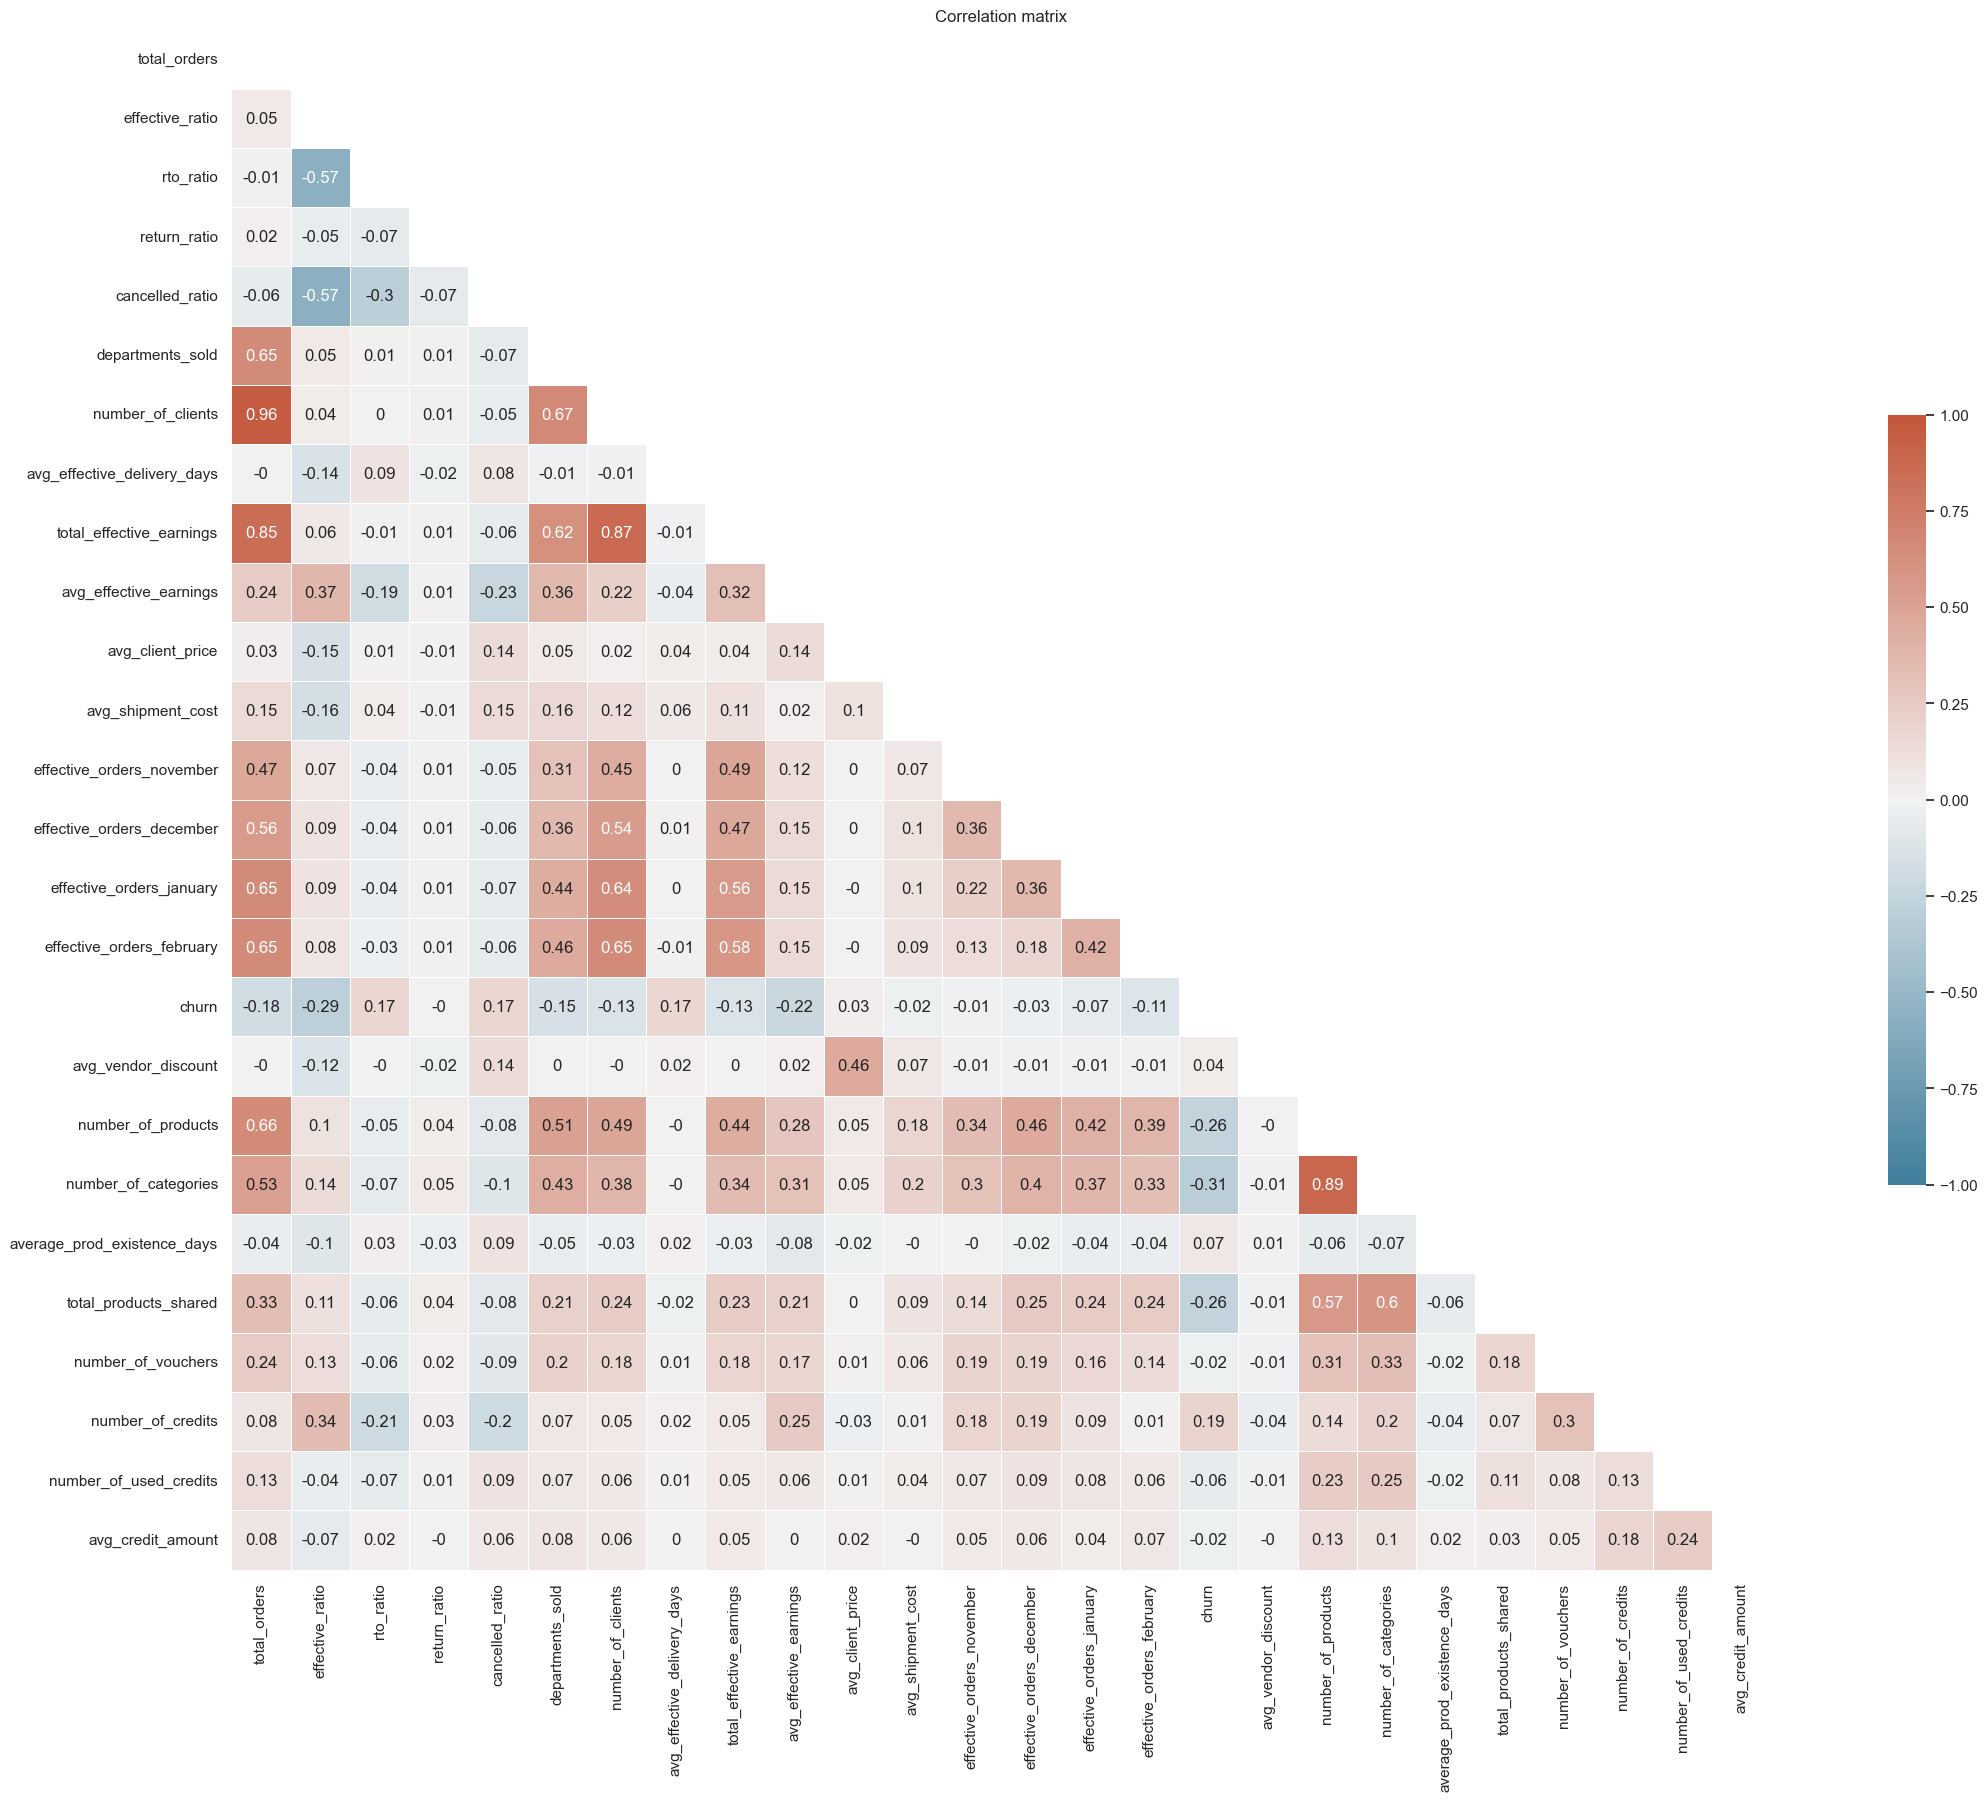

In [9]:
sns.set_theme(style="white")

# Compute the correlation matrix
corr = df02sellers2.corr().round(2)

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(30, 20))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmin=-1, vmax=1, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot=True)
plt.title("Correlation matrix")

To address multicolinearity, I will drop number_of_products and total_orders

Since the operational ratios add 1, return radio will be dropped

In [10]:
#Dropping number of products and total orders
df02sellers.drop(["number_of_products", "total_orders"], axis=1, inplace=True)

In [11]:
#Dropping return ratio
df02sellers.drop("return_ratio", axis=1, inplace=True)

In [12]:
#Reviewing the seller created at column
df02sellers["seller_created_at"].dtype

dtype('O')

In [13]:
#Seller created at:
#Convert to datetime
df02sellers["seller_created_at"] = pd.to_datetime(df02sellers["seller_created_at"])

#Seller creation month:
df02sellers["seller_creation_month"] = df02sellers["seller_created_at"].dt.month

#Sanity check
df02sellers["seller_created_at"]

seller_id
11415920   2022-09-30
11415923   2022-09-30
11415930   2022-09-30
11415933   2022-09-30
11415940   2022-09-30
              ...    
11886487   2023-04-27
11886505   2023-04-27
11886533   2023-04-27
11886542   2023-04-27
11886576   2023-04-27
Name: seller_created_at, Length: 47704, dtype: datetime64[ns]

In [14]:
#Days since seller creation

#Seller creation threshold:
seller_creation_threshold = pd.to_datetime("2023-04-30")

df02sellers["days_since_seller_creation"] = seller_creation_threshold - df02sellers["seller_created_at"]
df02sellers["days_since_seller_creation"] = df02sellers["days_since_seller_creation"].dt.days.astype(int)

In [15]:
df02sellers["days_since_seller_creation"]

seller_id
11415920    212
11415923    212
11415930    212
11415933    212
11415940    212
           ... 
11886487      3
11886505      3
11886533      3
11886542      3
11886576      3
Name: days_since_seller_creation, Length: 47704, dtype: int64

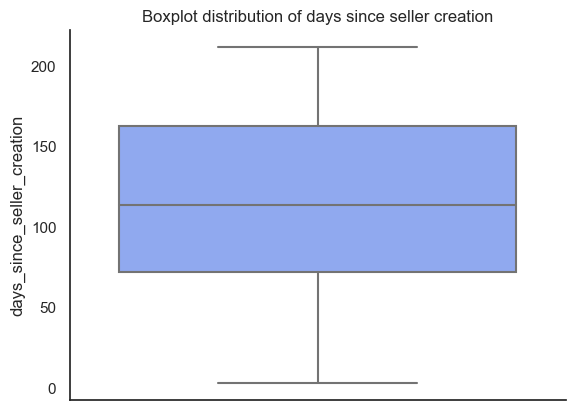

In [16]:
#Visualization of days since seller creation
plt.plot()
sns.boxplot(data= df02sellers,
             y=df02sellers["days_since_seller_creation"],color="#80a2ff")

plt.title("Boxplot distribution of days since seller creation")
sns.despine()

Text(0.5, 1.0, 'Days since seller creation: Elenas has been activating (>1 order) less sellers over time')

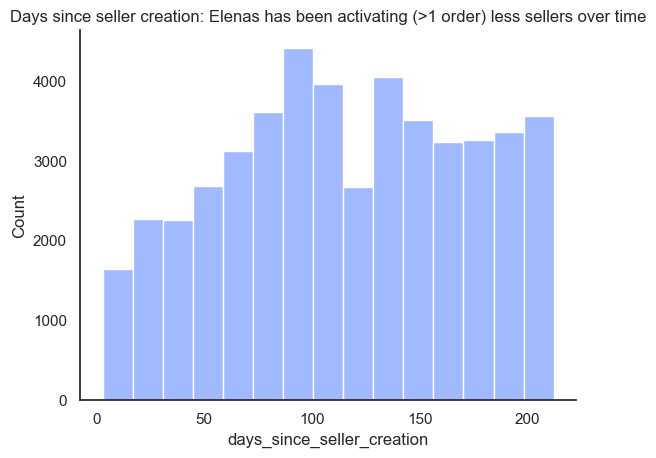

In [17]:
plt.plot()
sns.histplot(data= df02sellers,
             x=df02sellers["days_since_seller_creation"],
             bins=15,
             color="#80a2ff")
sns.despine()
plt.title("Days since seller creation: Elenas has been activating (>1 order) less sellers over time")

In [18]:
#Saving a new DF
df02sellers3 = df02sellers.copy()

#Reviewing the columns
df02sellers3.columns

Index(['seller_created_at', 'effective_ratio', 'rto_ratio', 'cancelled_ratio',
       'departments_sold', 'number_of_clients', 'avg_effective_delivery_days',
       'total_effective_earnings', 'avg_effective_earnings',
       'avg_client_price', 'avg_shipment_cost', 'total_discount',
       'effective_orders_november', 'effective_orders_december',
       'effective_orders_january', 'effective_orders_february', 'churn',
       'is_referred', 'avg_cart_items', 'avg_vendor_discount',
       'number_of_categories', 'average_prod_existence_days',
       'total_products_shared', 'number_of_vouchers', 'number_of_credits',
       'number_of_used_credits', 'avg_credit_amount', 'seller_creation_month',
       'days_since_seller_creation'],
      dtype='object')

### Data Distribution:

* A log transformation + 1 was applied to avg_effective_delivery_days and avg_effective_earnings

* Using the average effective earnings as a KPI could be misleading since it does not follow a normal distribution, so the average does not represent the majority of sellers

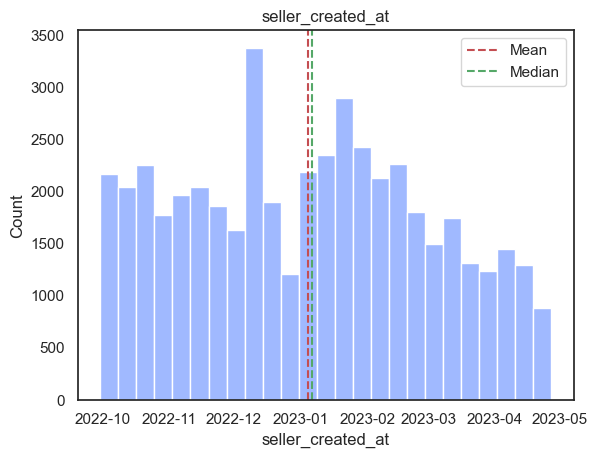

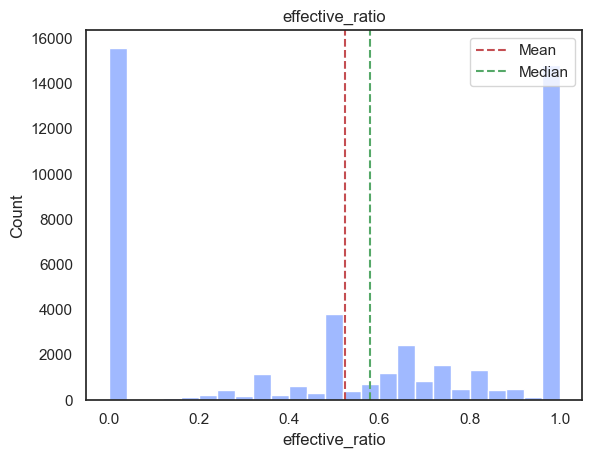

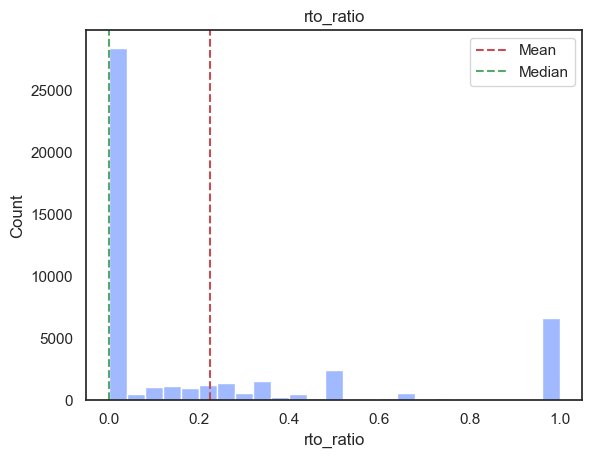

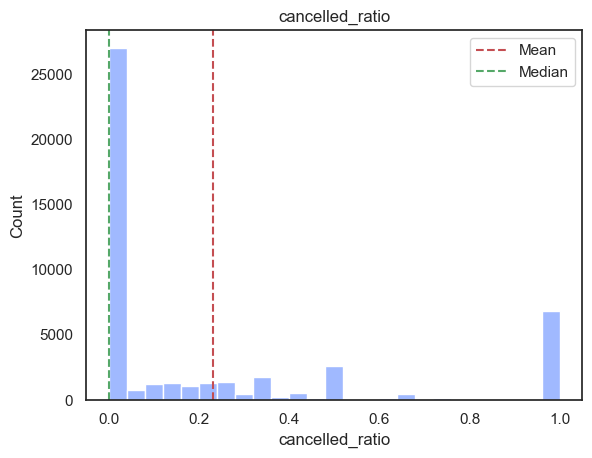

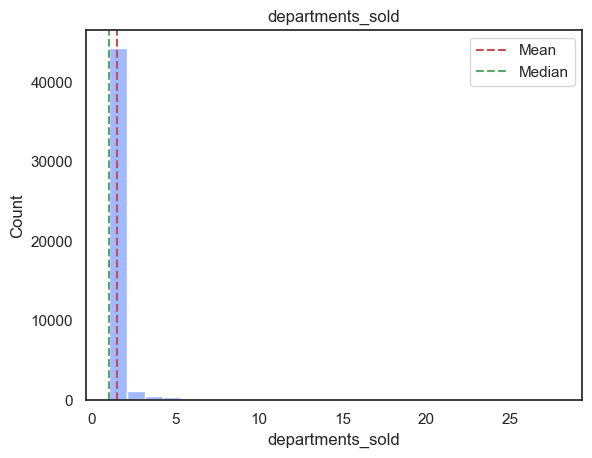

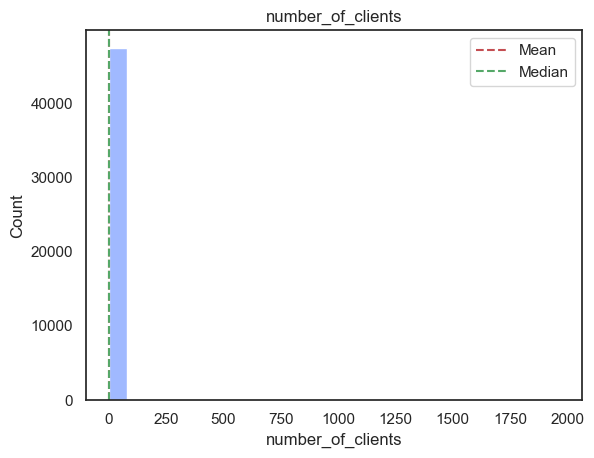

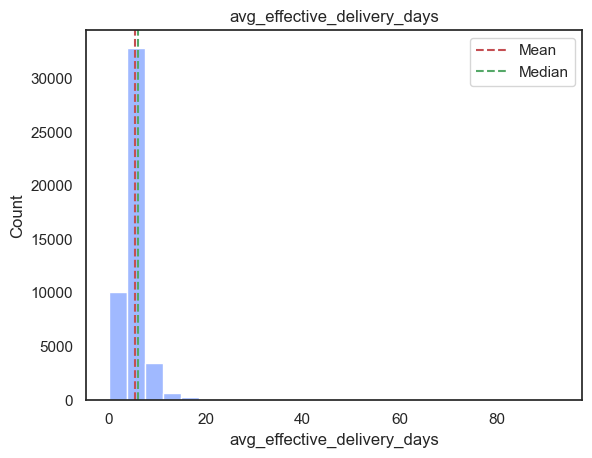

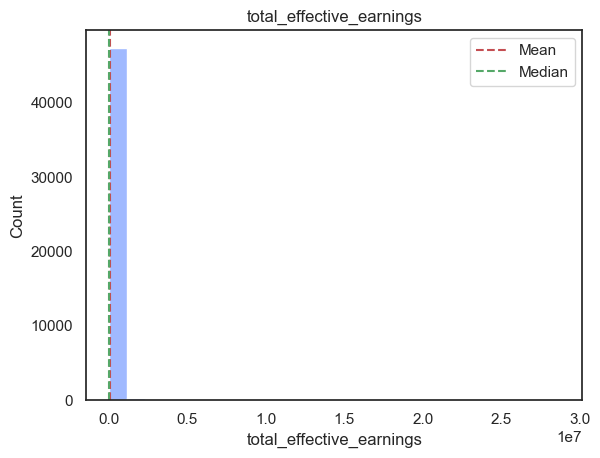

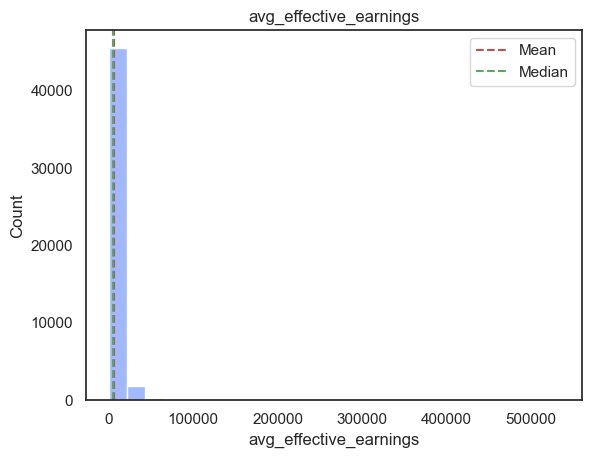

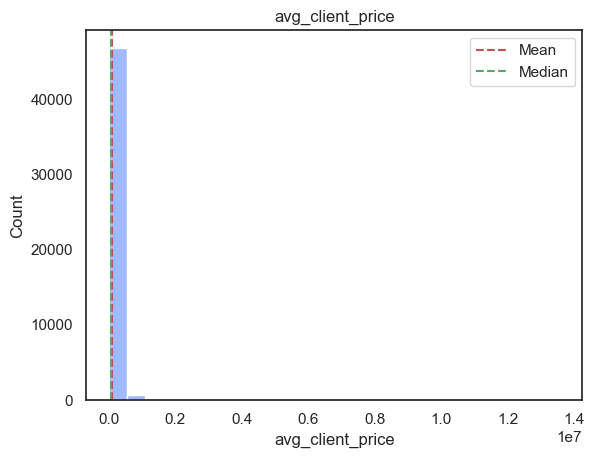

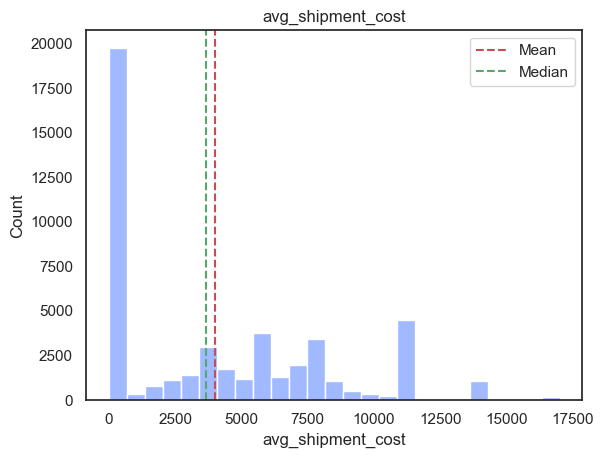

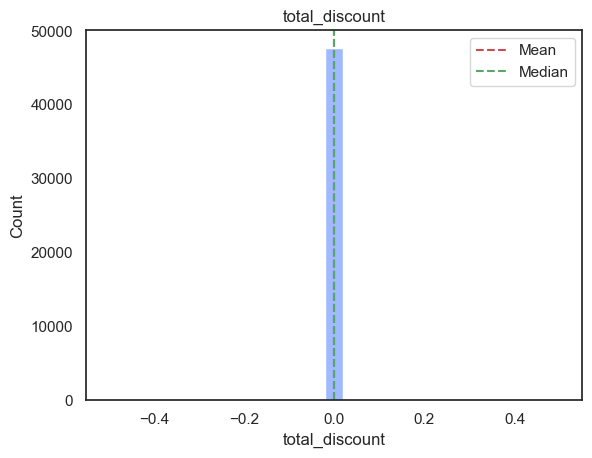

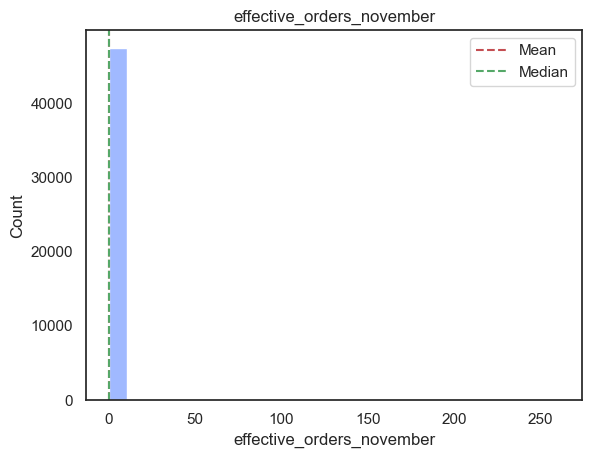

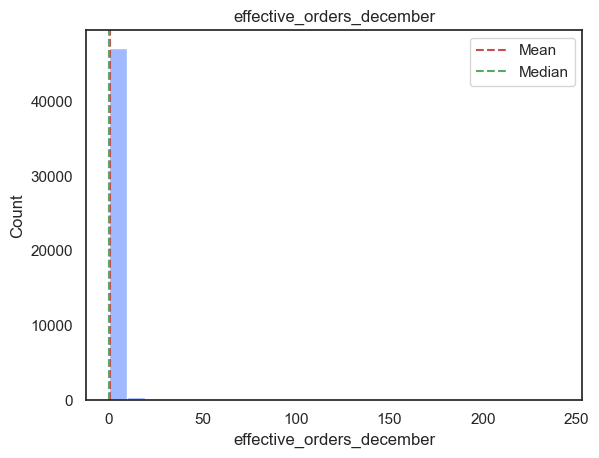

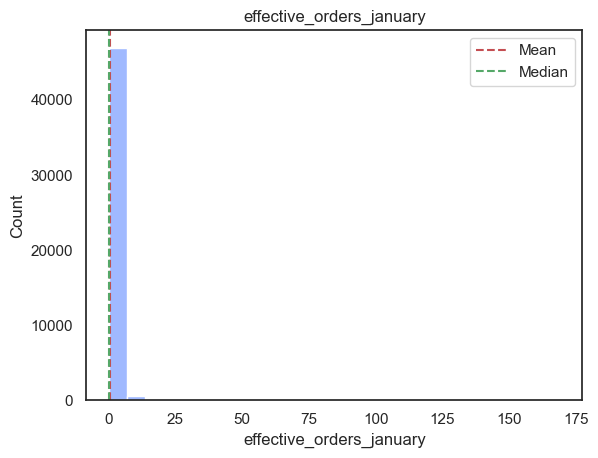

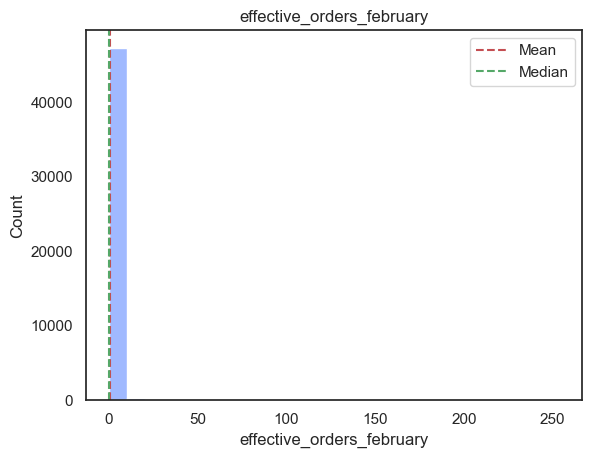

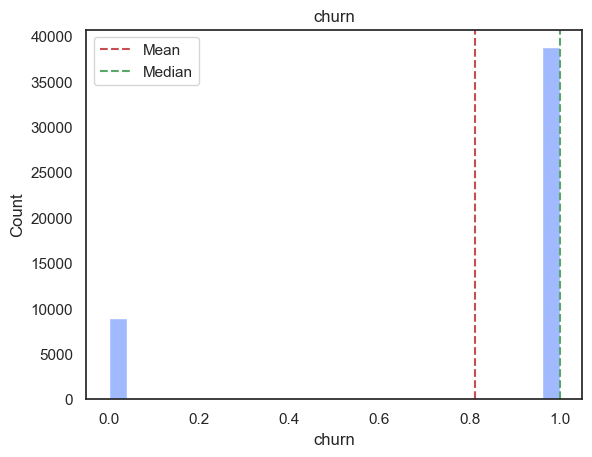

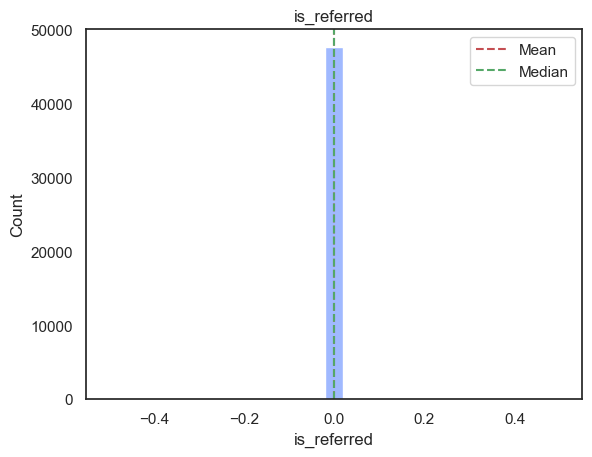

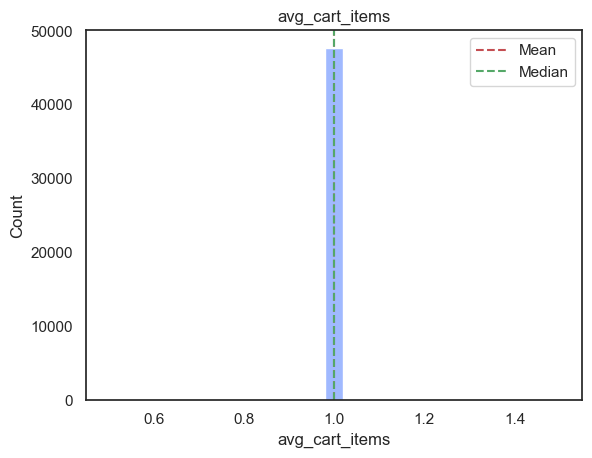

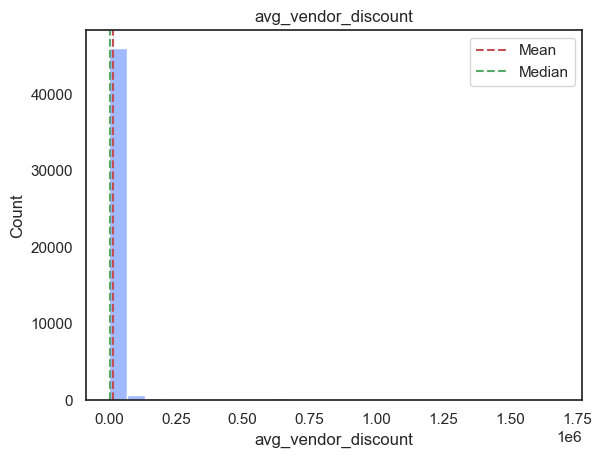

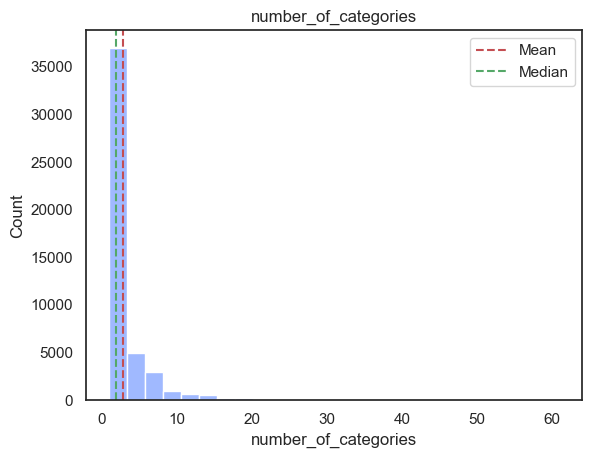

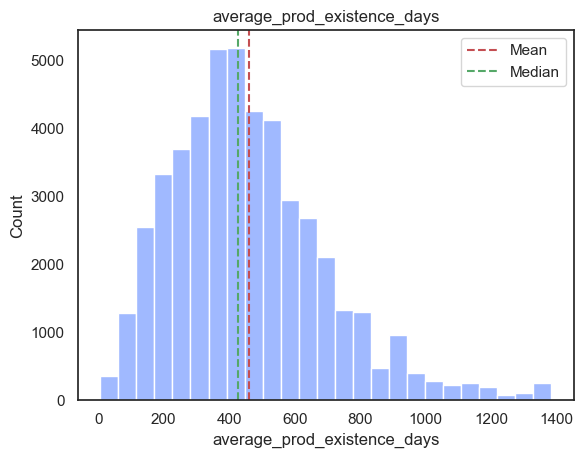

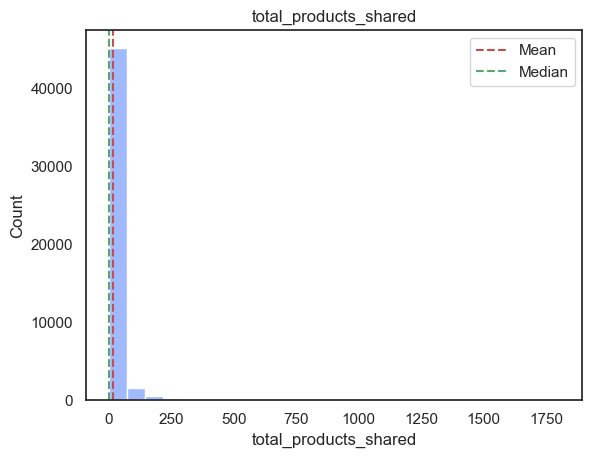

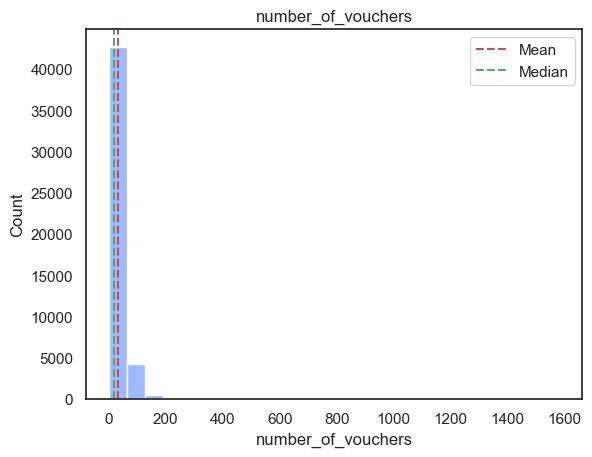

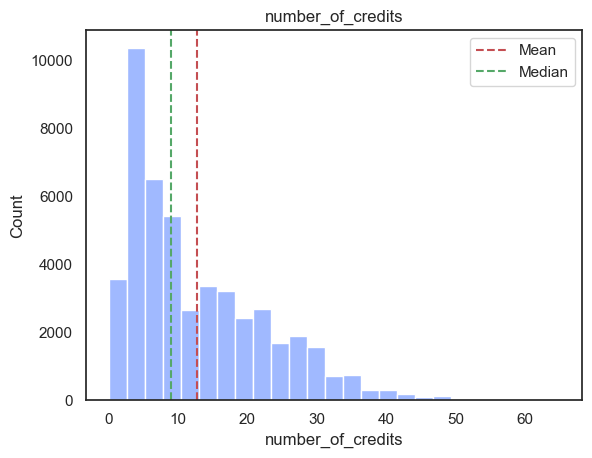

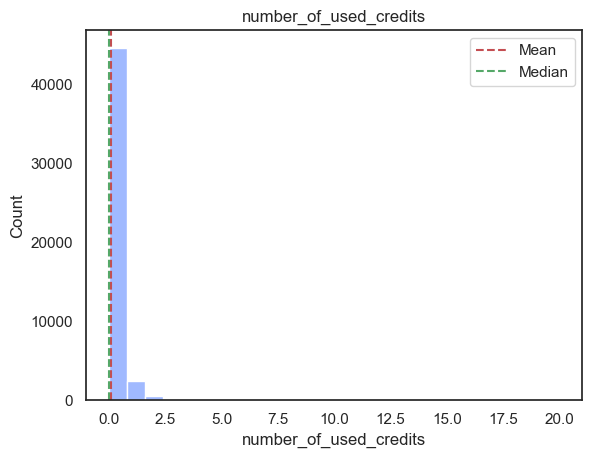

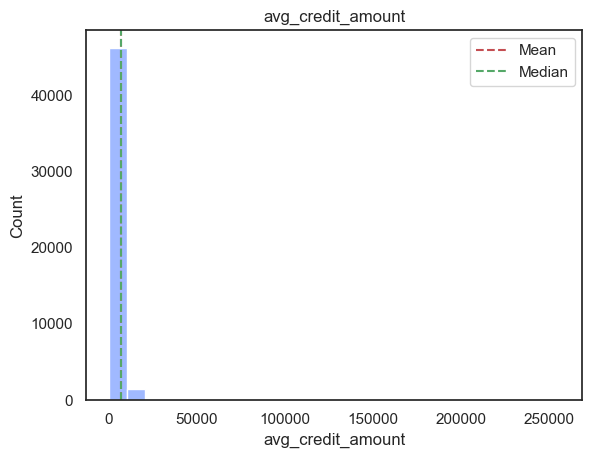

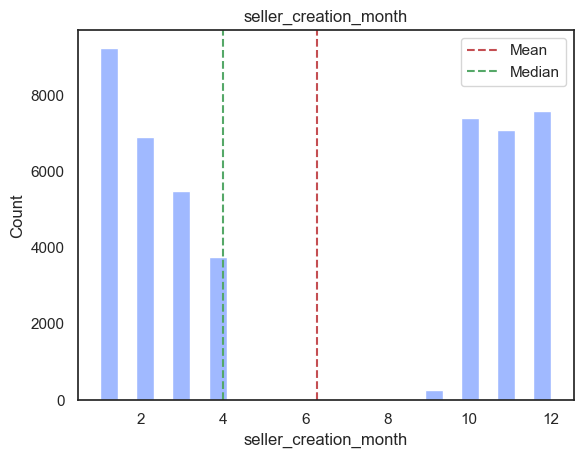

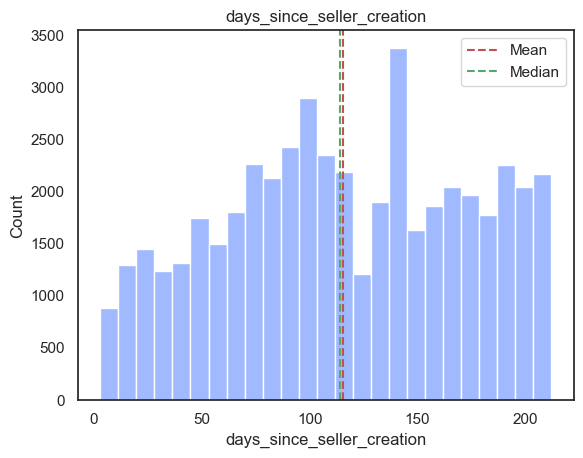

In [19]:
#Plotting distributions to determine if there are existing power laws
num_cols = df02sellers3.columns.to_list()

num_col_dist(num_cols, df02sellers3)


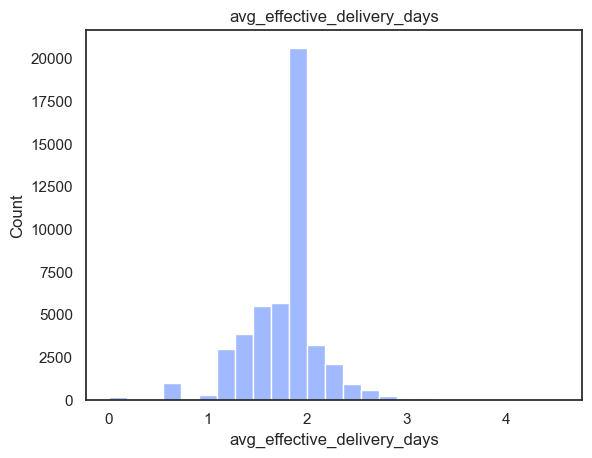

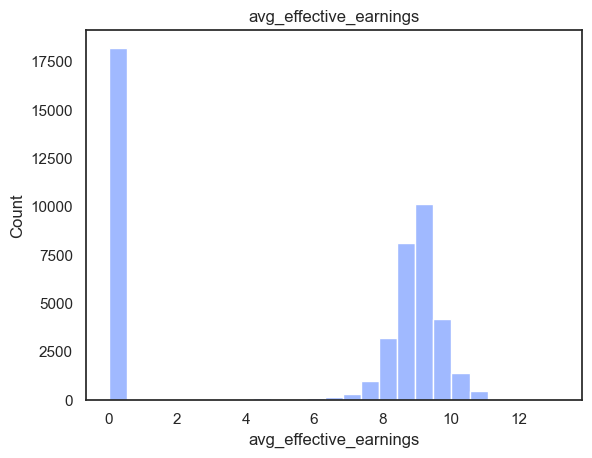

In [20]:
# Applying log transformation
log_cols = ["avg_effective_delivery_days", "avg_effective_earnings"]

for c in log_cols:
    plt.figure()
    sns.histplot(data=np.log1p(df02sellers3[c]), bins=25, color="#80a2ff")
    plt.xlabel(c)
    plt.title(c)
    plt.show()

In [21]:
#Log transformation:
#Avg effective delivery days
df02sellers3["avg_effective_delivery_days"] = np.log(df02sellers3["avg_effective_delivery_days"]+1)

#Avg effective earnings
df02sellers3["avg_effective_earnings"] = np.log(df02sellers3["avg_effective_earnings"]+1)

In [22]:
#Checkpoint:
df02sellers3.to_csv('../Data/elenas-it2-postpreprocessing.csv')

In [23]:
#DF measures
df_cols = df02sellers3.columns

print(len(df_cols))

print(df02sellers3.shape)

29
(47704, 29)


In [24]:
#Dropping columns that don't add value:
df02sellers4 = df02sellers3.drop(["total_discount", "is_referred", "avg_cart_items"], axis=1)


/var/folders/27/tbf7s19s47137sfh7rlj9pvh0000gn/T/ipykernel_4042/819106124.py:4: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr = df02sellers4.corr().round(2)


Text(0.5, 1.0, 'Iteration 2, after preprocessing correlation matrix: multicolinearity is still present')

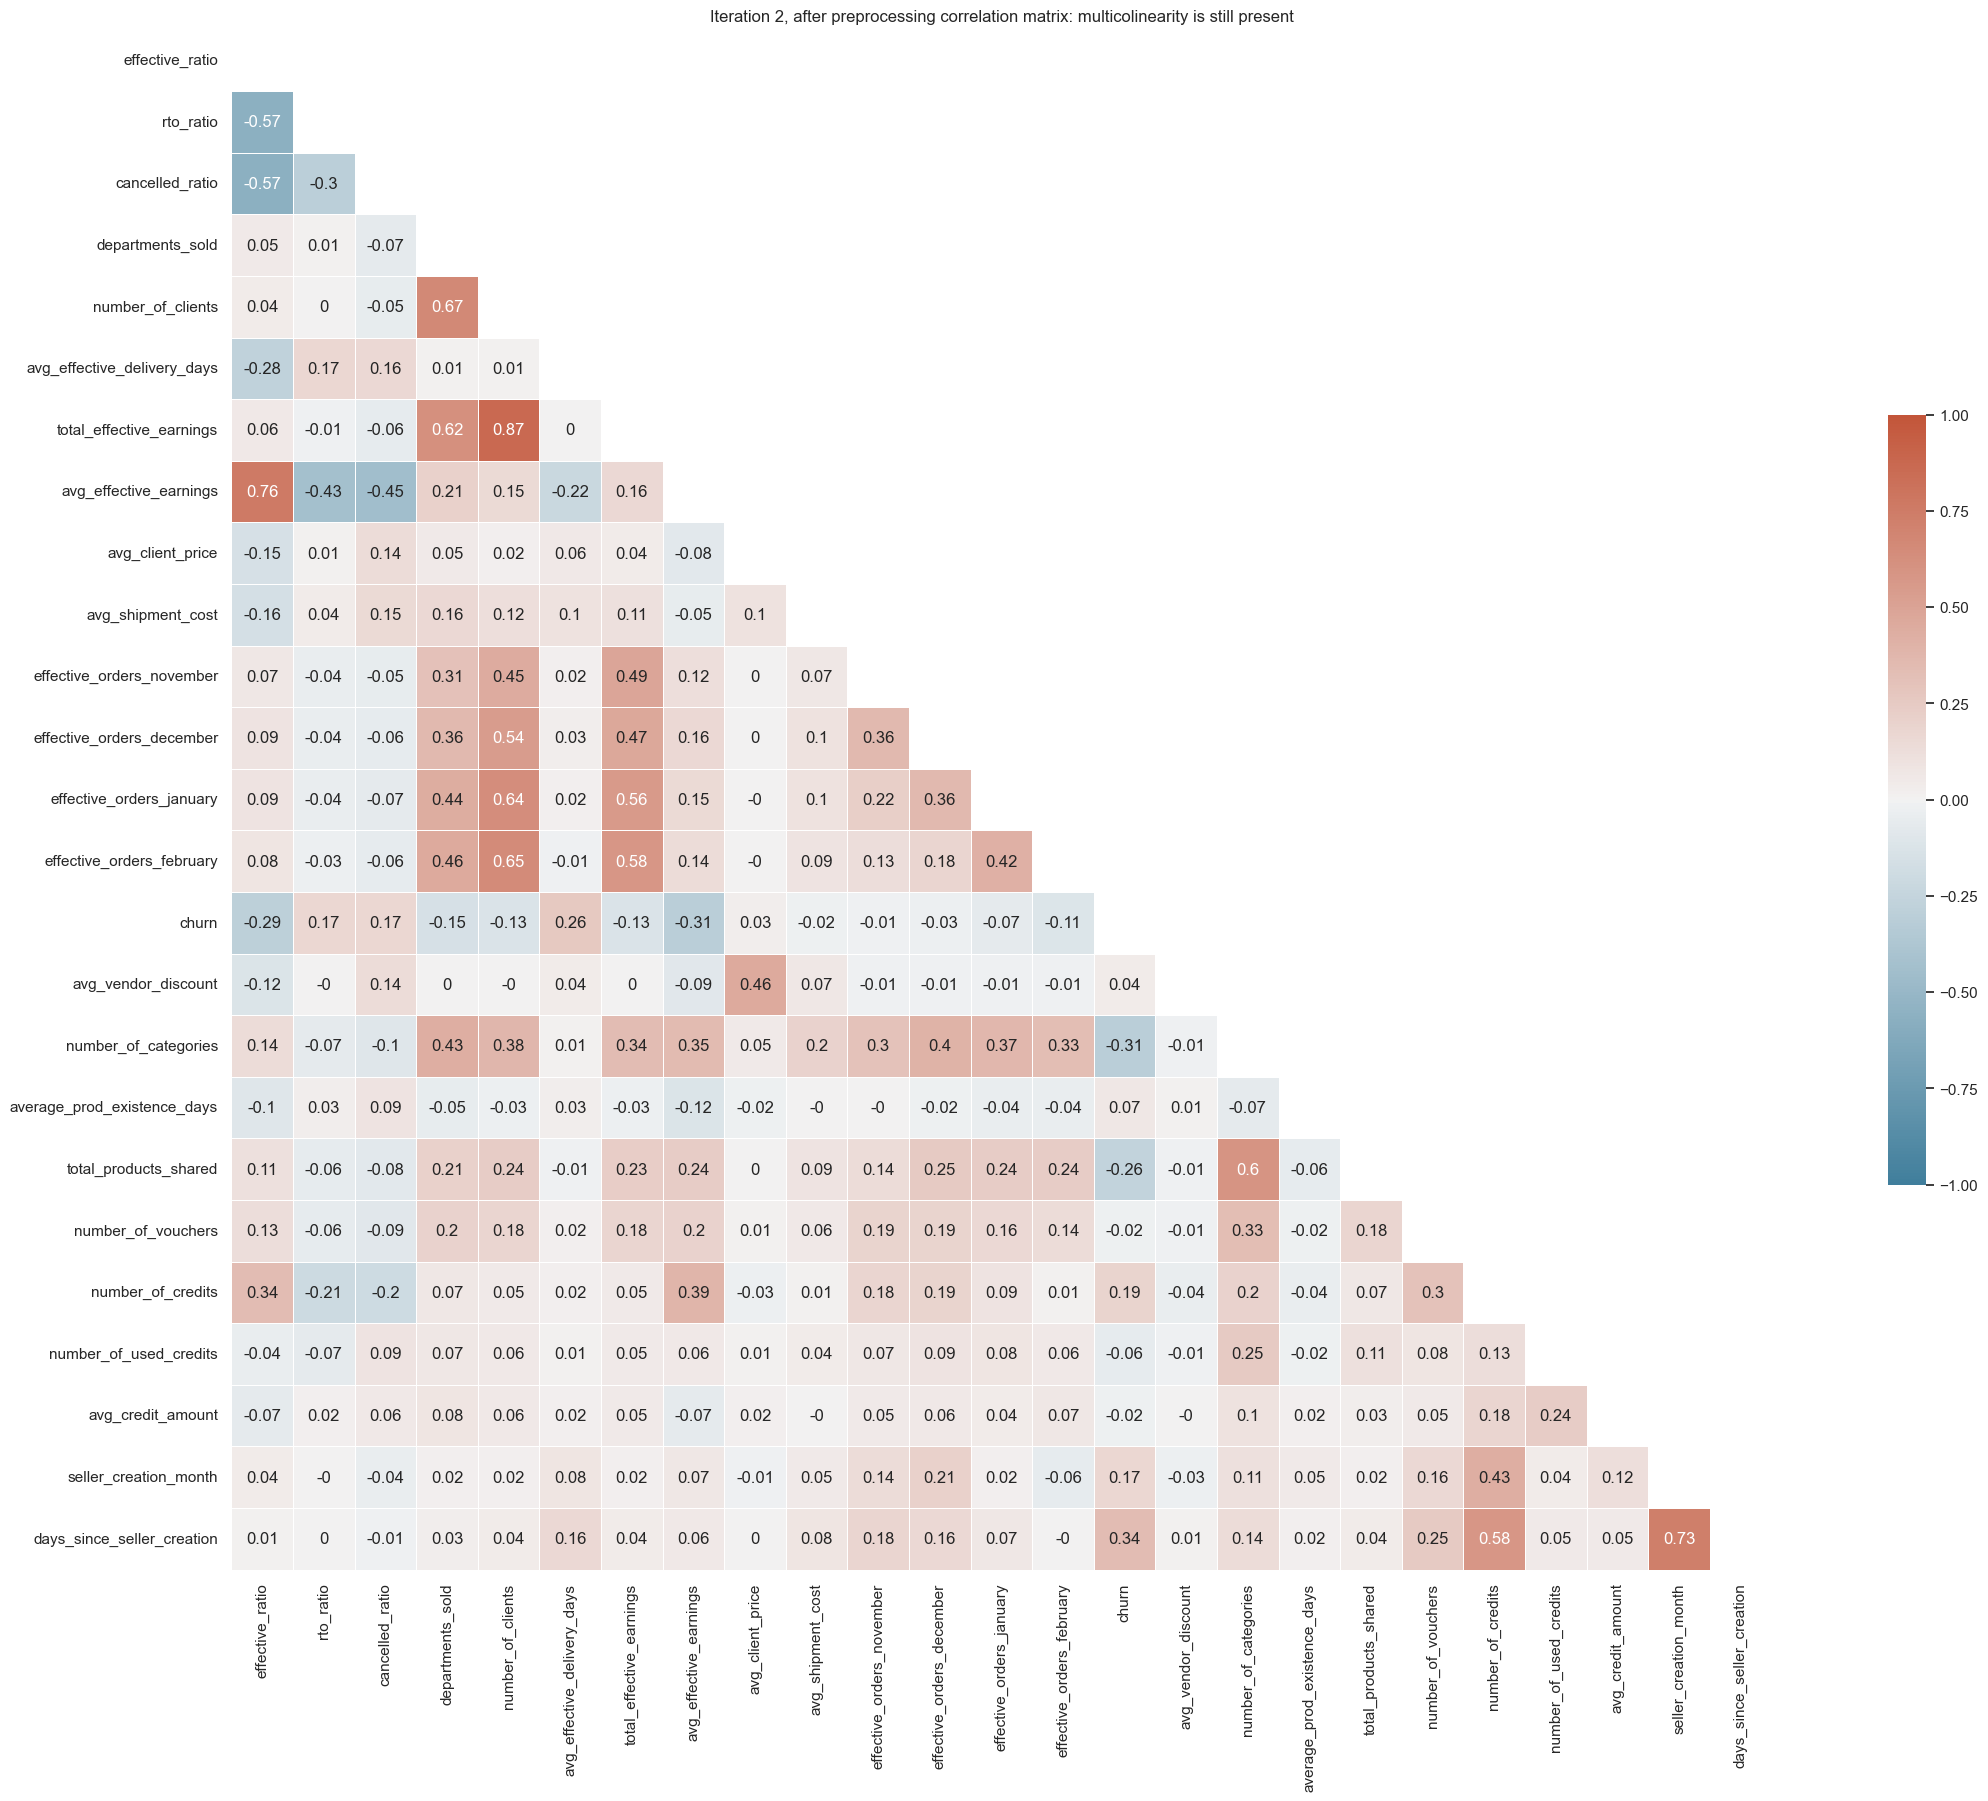

In [25]:
sns.set_theme(style="white")

# Compute the correlation matrix
corr = df02sellers4.corr().round(2)

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(30, 20))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmin=-1, vmax=1, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot=True)
plt.title("Iteration 2, after preprocessing correlation matrix: multicolinearity is still present")

After correcting and eliminating some columns, there is still multicollinearity. This should be taken into account for the modelling

---

## Iteration 1 preprocessing

- Since the target variable is quite imbalanced (90% of sellers churned), the baseline model would be to return that all of them churned and get a 90% accuracy. So values above that mark would be interesting.
- For the baseline model I used a simple decision tree iterating through 2 depth levels and cross folding to ensure reliable results. The choice on the model was based on multicollinearity and the scale of the data.
- Based on the variables used by the baseline tree, I decided to create related features:
    1. Days since seller creation date
    2. Month of seller creation
- Based on the distribution of the data, I decided to perform log transformation on avg_effective_delivery_days and avg_effective_earnings
- I splitted X and y, stratified into 80% test, 20% train, performed smote resample and standard scaler

The Standar Scaler of this iteration, creates a data leakage risk, which is addressed for the second iteration

### Baseline model

**Baseline model**
- Decision tree parameters and score:
    - parameters: max depth 2, no scaling
    - accuracy: 91, since the model is higher than the baseline, the results are interesting
    - AUC: 0.78
- Plotting the tree: the main variables for the segmentations were number of shared products and sellerID. Since the first one is an aggregate of all the time the seller has used the platform and the second one is continuous numerical data. I will include features to account for this situation, for example: days since seller creation date

- Additionally, I will continue to use recall as an evaluation metric for the next model

In [26]:
#import and splitting
df8 = pd.read_csv("../data/elenas-it1-preprocessed4.csv",index_col=0)

#Creating a copy for the baseline
dfbaseline = df8.copy()

#Dropping non-numerical columns
dfbaseline.drop("created_at", axis=1, inplace=True)

#Splitting
X = dfbaseline.drop(columns="order_last_month")
y = dfbaseline["order_last_month"]

#Splitting data
X_trainbl, X_testbl, y_trainbl, y_testbl = train_test_split(X,y, test_size=0.2, stratify=y, random_state=24)

In [27]:
#Baseline Model
estimators = [('normalise', StandardScaler()),
              ('model', DecisionTreeClassifier())]

pipe = Pipeline(estimators)

param_grid = [
            {'model': [DecisionTreeClassifier()],
             'normalise': [None], 'model__max_depth': [1, 2]}
]

grid = GridSearchCV(pipe, param_grid, cv=5, verbose = 1)
fittedgrid = grid.fit(X_trainbl, y_trainbl)

Fitting 5 folds for each of 2 candidates, totalling 10 fits


In [28]:
#Sanity check: Returning the best params:
fittedgrid.best_params_

{'model': DecisionTreeClassifier(max_depth=2),
 'model__max_depth': 2,
 'normalise': None}

In [29]:
#Measuring the score
print(f"accuracy score: {fittedgrid.score(X_testbl, y_testbl):.2f}") 

accuracy score: 0.92


In [30]:
# Probabilities from the fitted grid search
y_pred_prob = fittedgrid.predict_proba(X_testbl)[:, 1]

# FPR, TPR and Thresholds
fpr, tpr, thresholds = roc_curve(y_testbl, y_pred_prob)

#AUC score
auc_score = roc_auc_score(y_testbl, y_pred_prob)

#ROC curve 
roc_trace = go.Scatter(
    x=fpr,
    y=tpr,
    mode='lines',
    name='ROC Curve (AUC = {:.2f})'.format(auc_score)
)

#Diagonal line trace
diagonal_trace = go.Scatter(
    x=[0, 1],
    y=[0, 1],
    mode='lines',
    name='Diagional line (equal measures)',
    line=dict(dash='dash')
)

#Layout & figure
layout = go.Layout(
    title='Receiver Operating Characteristic (ROC) Curve',
    xaxis=dict(title='False Positive Rate'),
    yaxis=dict(title='True Positive Rate'),
    showlegend=True
)

fig = go.Figure(data=[roc_trace, diagonal_trace], layout=layout)


fig.show()


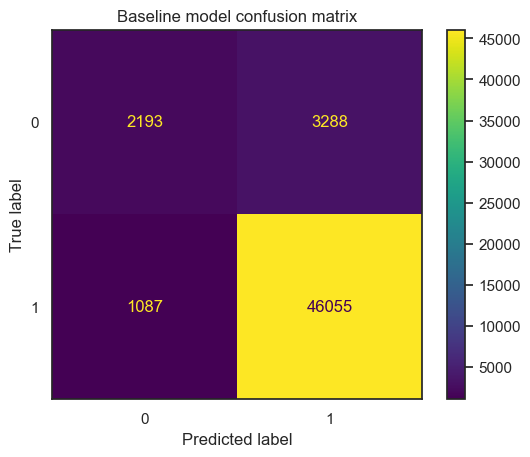

In [31]:
# Confusion matrix
cm = confusion_matrix(y_testbl, fittedgrid.predict(X_testbl), labels=fittedgrid.best_estimator_.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=fittedgrid.best_estimator_.classes_)
disp.plot()
plt.title("Baseline model confusion matrix")
plt.show()

In [32]:
print(f"Precision: accuracy of churn predictions: {precision_score(y_testbl,fittedgrid.predict(X_testbl))}")
print(f"Recall: how many of the actual churns are correctly predicted as churn: {recall_score(y_testbl,fittedgrid.predict(X_testbl))}")
print(f"F1 score: {f1_score(y_testbl,fittedgrid.predict(X_testbl))}")


Precision: accuracy of churn predictions: 0.9333644083253957
Recall: how many of the actual churns are correctly predicted as churn: 0.9769420050061516
F1 score: 0.9546561641705964


### Data preprocessing:

**Seller created_at:**  this column could be used to obtain 3 more features that could be valuable:
1. Days since creation: it is expected that a relevant fraction of the sellers that started in 2021 have already churned.
2. Seller creation month: It would be relevant to understand if there is an influence or seasonality depending on the month where they signed up. For examples, the ones in november - december that is the peak season in latam, could create the accounts to purchase for themselves instead of selling. 
3. Binning on seller creation days depending on the part of the month, since the incentives to acquire them are different


In [33]:
#Seller Created at review:
#Convert to datetime
df8["created_at"] = pd.to_datetime(df8["created_at"])

#Seller creation month:
df8["seller_creation_month"] = df8["created_at"].dt.month

In [34]:
#Test to extract the days difference
df_test = df8.copy()

#Establishing the threshold date
threshold_date = pd.Timestamp('2023-03-30')

#Subtraction
df_test["creation_days"] = (threshold_date - df_test["created_at"]).dt.days

#Sanity check
df_test[["created_at", "creation_days"]].head(5)

,created_at,creation_days
0,2022-12-08,112
1,2022-12-11,109
2,2022-12-16,104
3,2022-12-23,97
4,2022-12-31,89


In [35]:
#Days since seller creation

#Seller creation threshold:
seller_creation_threshold = pd.Timestamp("2023-03-30")

#Substracting the dates
df8["days_since_seller_creation"] = (seller_creation_threshold - df8["created_at"])

#Converting into int
df8["days_since_seller_creation"] = df8["days_since_seller_creation"].astype(int)

#sanity check:
df8["days_since_seller_creation"].dtypes

dtype('int64')

In [36]:
#Creating days of the month column
df8["days"] = df8["created_at"].dt.day
print(df8["days"].describe().round(0))

#binning
df8["creation_time_of_month"] = pd.cut(df8["days"], bins=[0, 10, 20, 32], labels=[1, 2, 3])

#converting to int
df8["creation_time_of_month"] = df8["creation_time_of_month"].astype(int)

#Sanity check:
df8["creation_time_of_month"].value_counts()

count    263113.0
mean         16.0
std           9.0
min           1.0
25%           8.0
50%          15.0
75%          23.0
max          31.0
Name: days, dtype: float64


3    89089
2    88553
1    85471
Name: creation_time_of_month, dtype: int64

In [37]:
#Dropping the columns:
cols_to_drop =["created_at", "days", "user_id", "number_of_clients", "return_ratio"]

df10 = df8.copy()

df10.drop(columns=cols_to_drop, inplace=True)

### Data distribution
- I plotted the different distributions of the variables. Some seemed like exponential distributions so decided to further analyze applying log transformation and plot them again. After the exercise decided to transform:
1. avg_effective_delivery_days
2. avg_effective_earnings

In [38]:
#Plotting distributions to determine if there are existing power laws
num_cols = df10.columns.to_list()

#Removing seller_id
num_cols.remove("seller_id")

#Removing activation time of month:
num_cols.remove("creation_time_of_month")


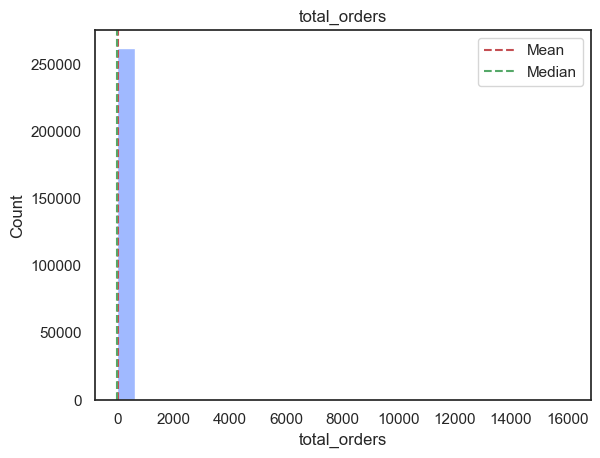

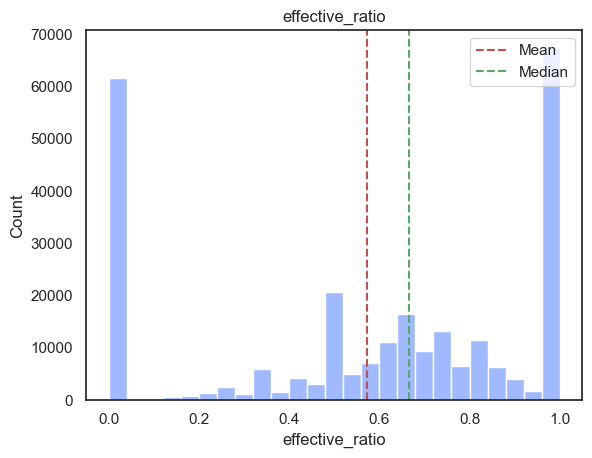

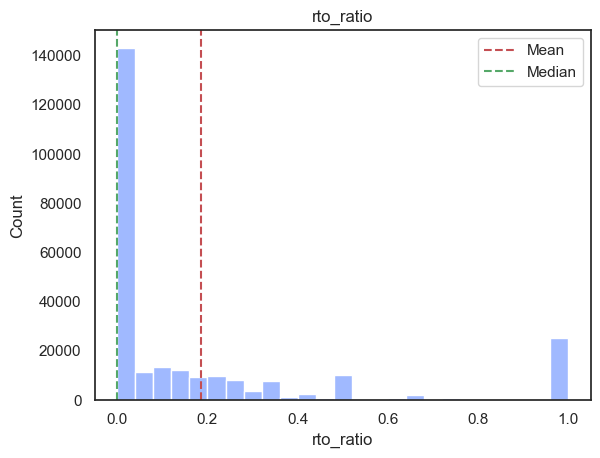

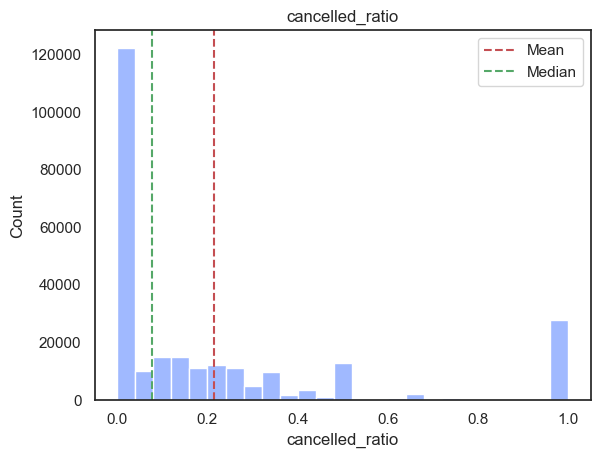

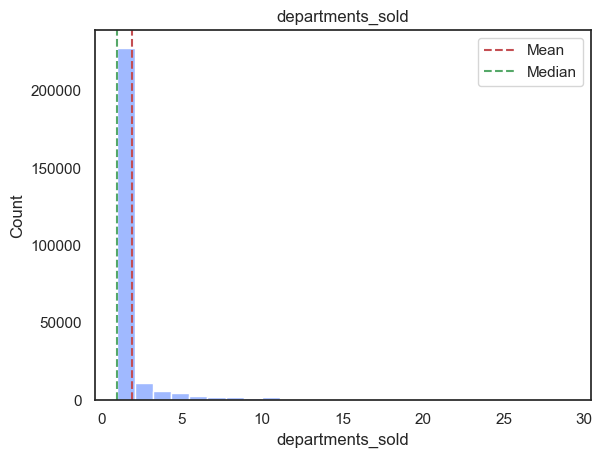

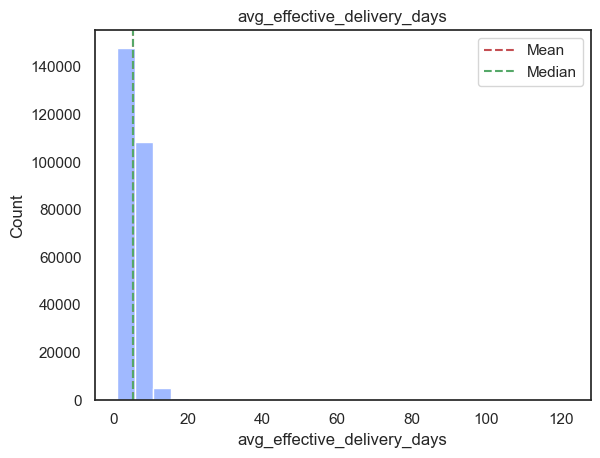

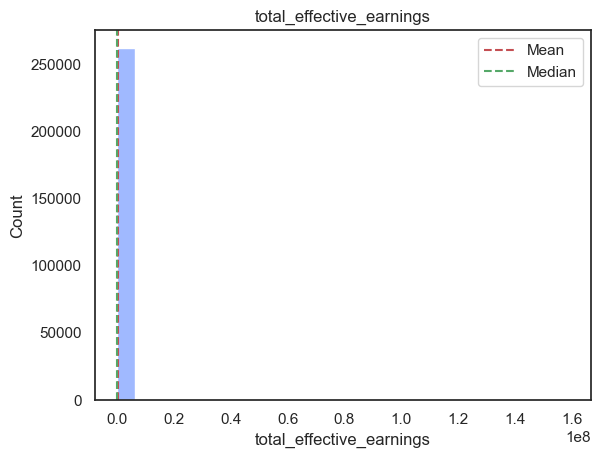

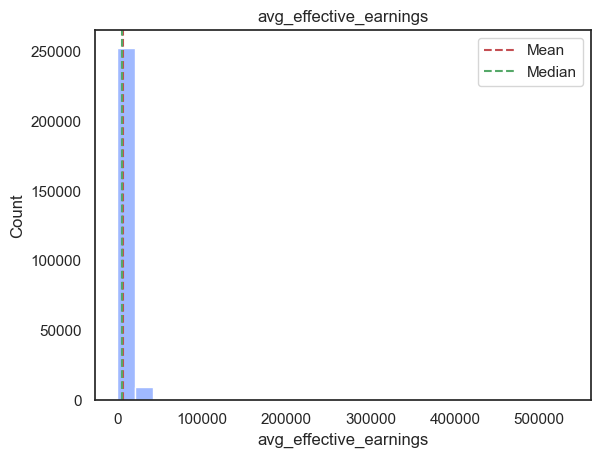

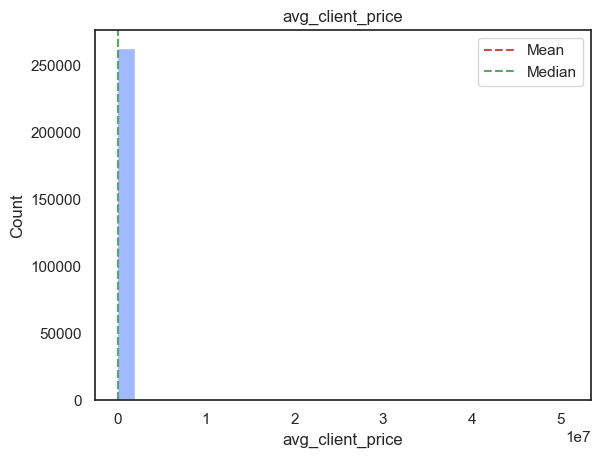

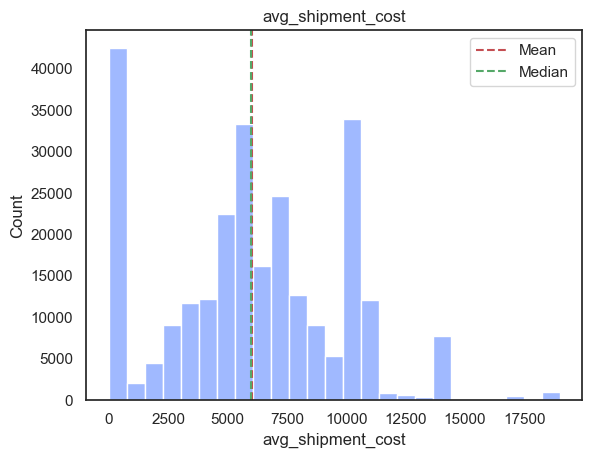

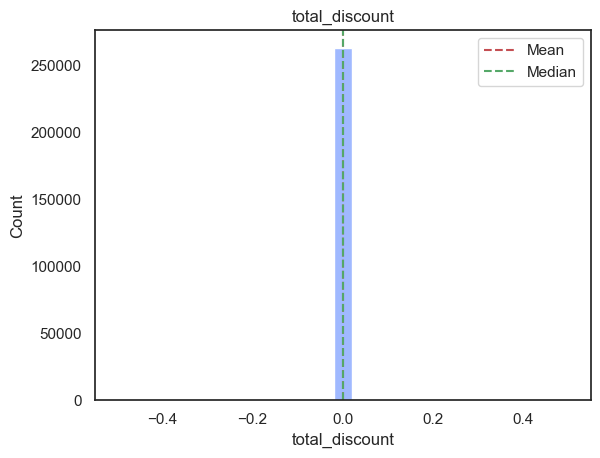

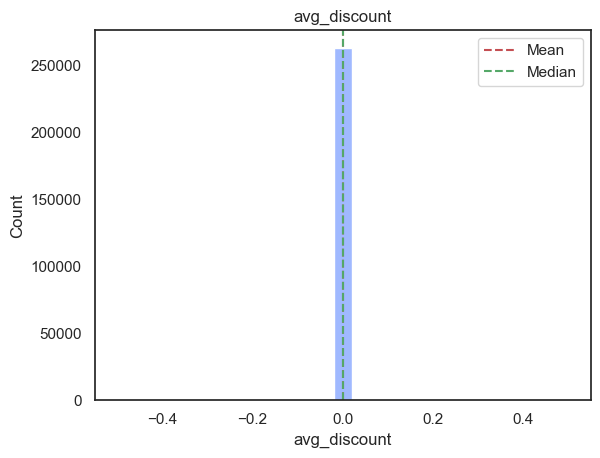

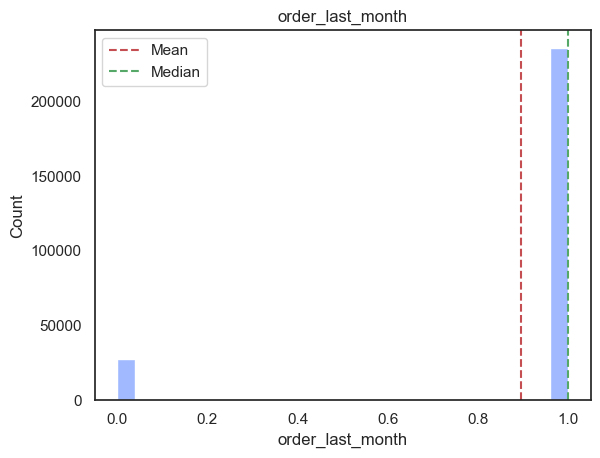

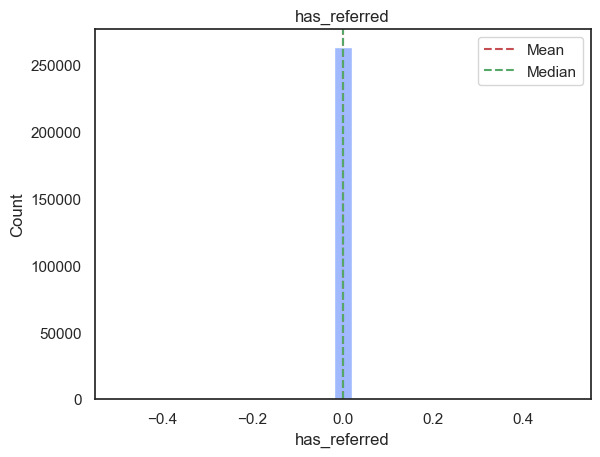

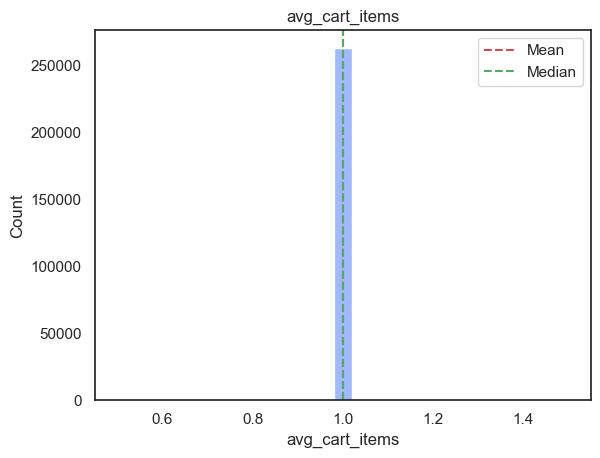

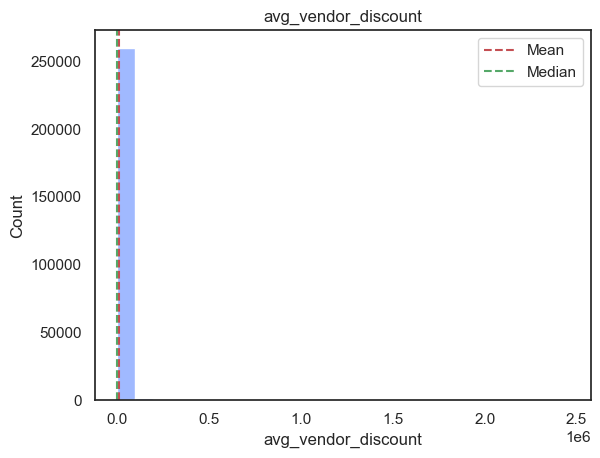

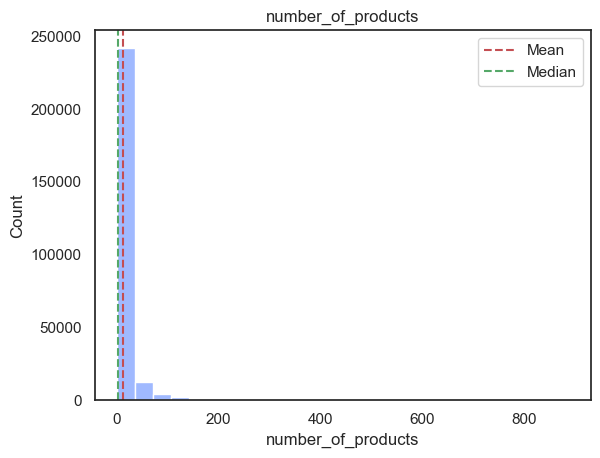

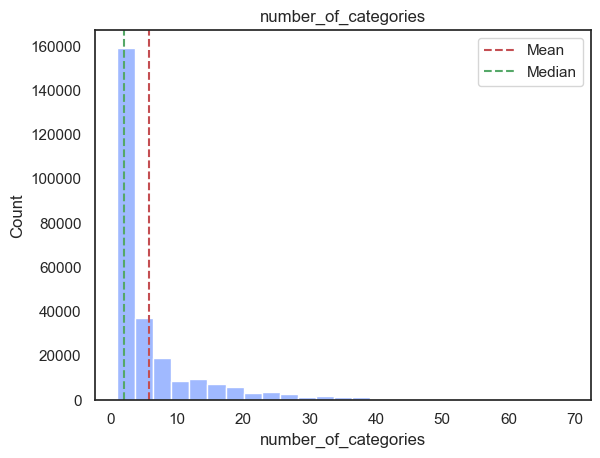

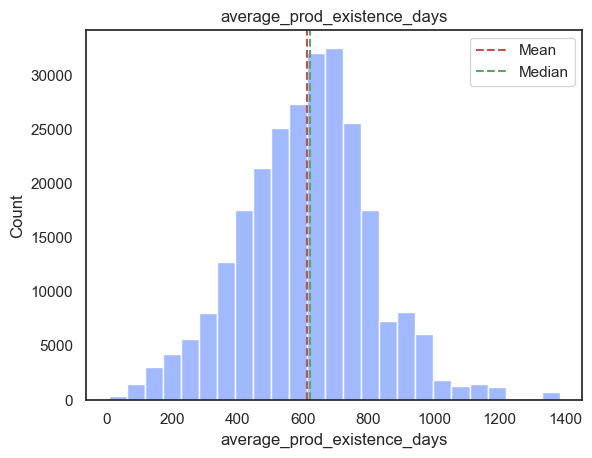

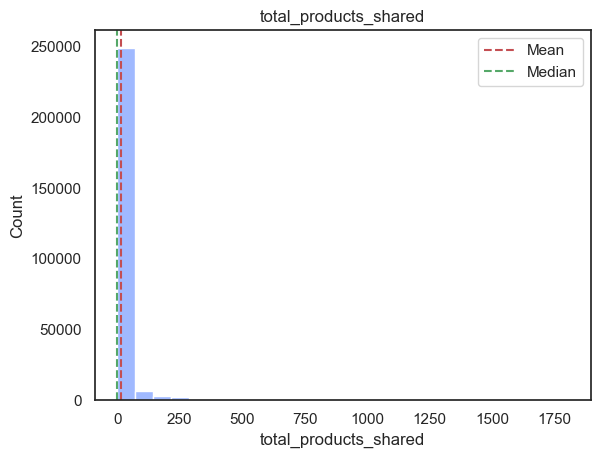

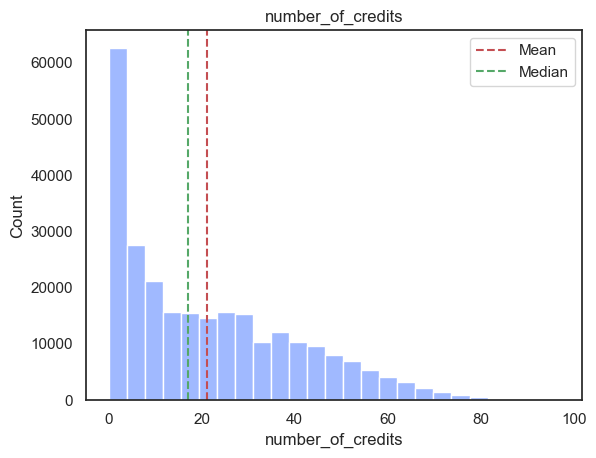

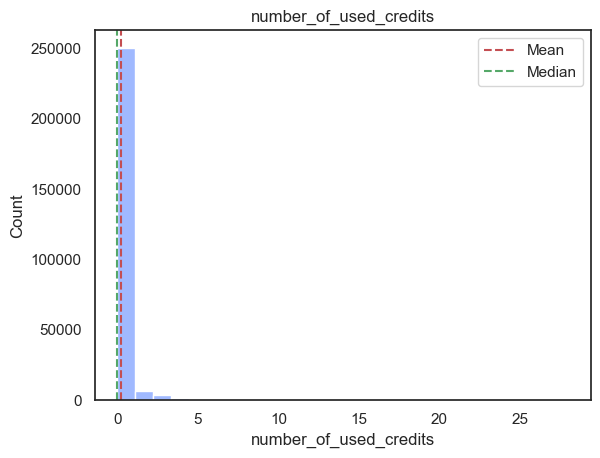

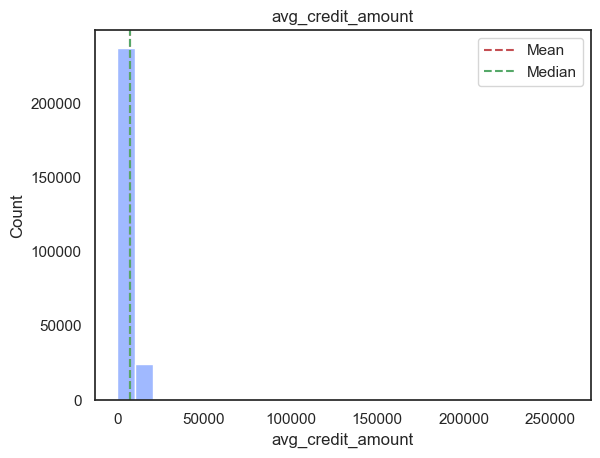

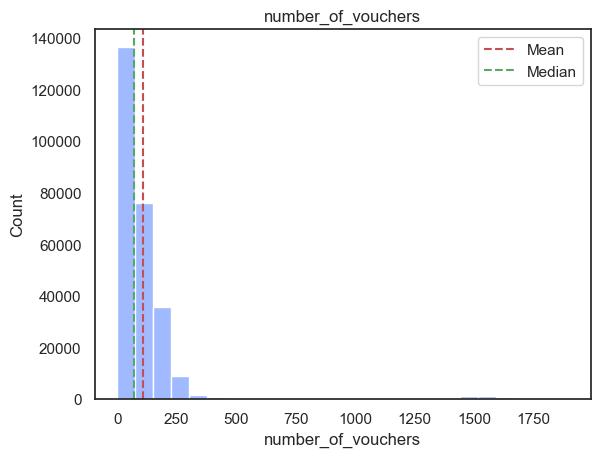

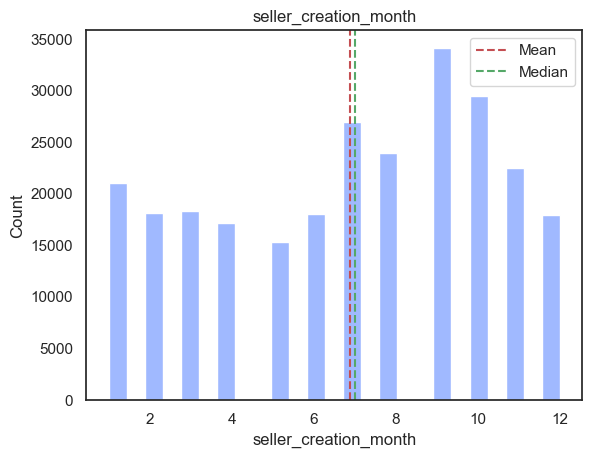

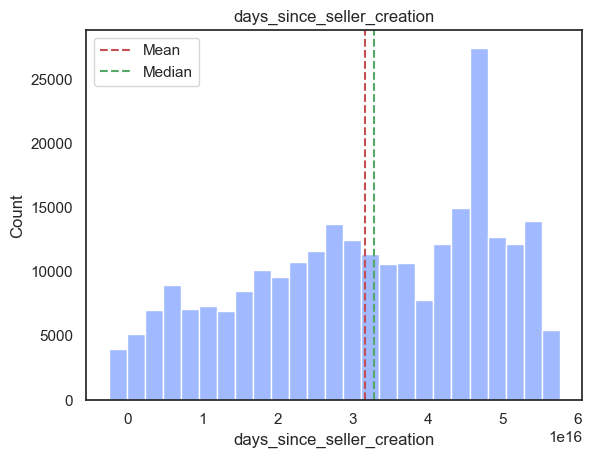

In [39]:
num_col_dist(num_cols, df10)

/Users/mauriciomoreno/opt/anaconda3/envs/capstone_shap/lib/python3.8/site-packages/pandas/core/internals/blocks.py:351: RuntimeWarning:

invalid value encountered in log

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


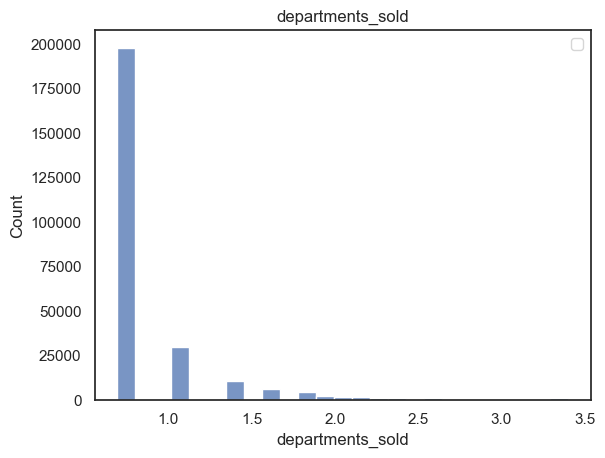

/Users/mauriciomoreno/opt/anaconda3/envs/capstone_shap/lib/python3.8/site-packages/pandas/core/internals/blocks.py:351: RuntimeWarning:

invalid value encountered in log

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


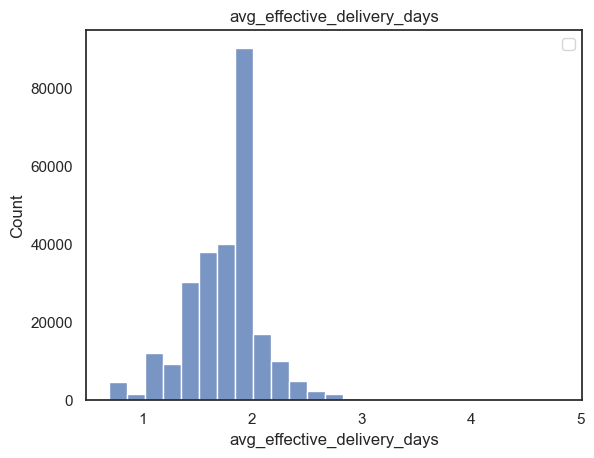

/Users/mauriciomoreno/opt/anaconda3/envs/capstone_shap/lib/python3.8/site-packages/pandas/core/internals/blocks.py:351: RuntimeWarning:

invalid value encountered in log

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


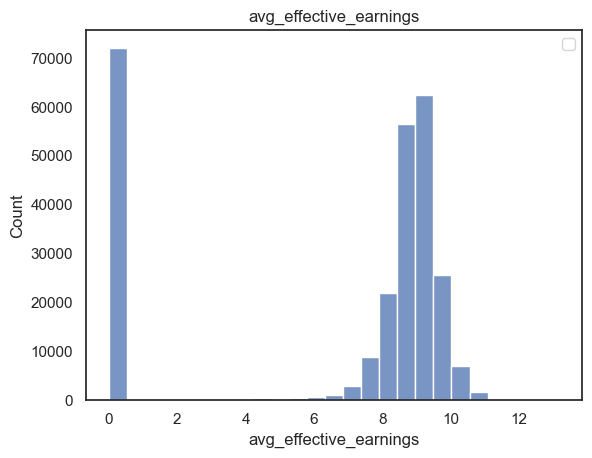

/Users/mauriciomoreno/opt/anaconda3/envs/capstone_shap/lib/python3.8/site-packages/pandas/core/internals/blocks.py:351: RuntimeWarning:

invalid value encountered in log

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


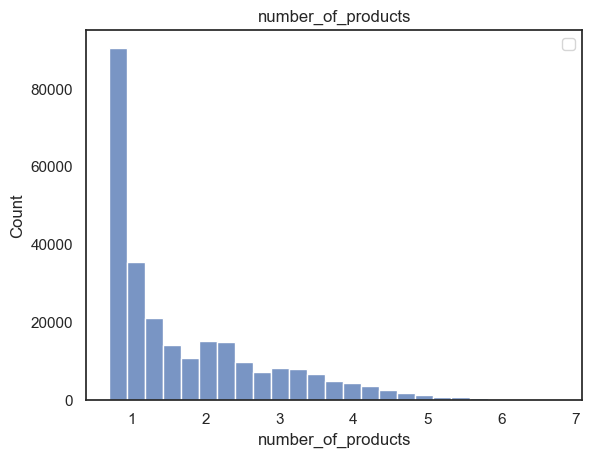

/Users/mauriciomoreno/opt/anaconda3/envs/capstone_shap/lib/python3.8/site-packages/pandas/core/internals/blocks.py:351: RuntimeWarning:

invalid value encountered in log

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


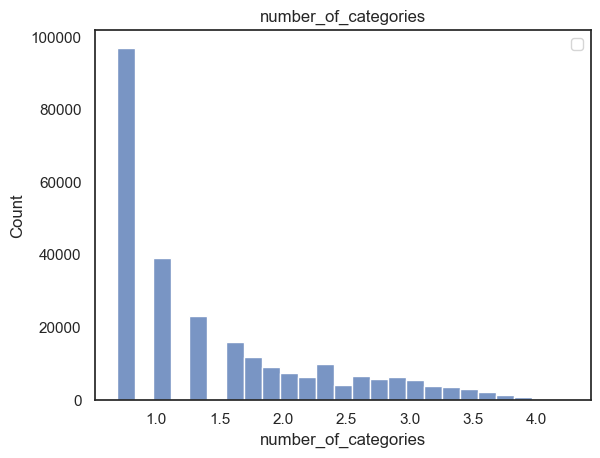

/Users/mauriciomoreno/opt/anaconda3/envs/capstone_shap/lib/python3.8/site-packages/pandas/core/internals/blocks.py:351: RuntimeWarning:

invalid value encountered in log

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


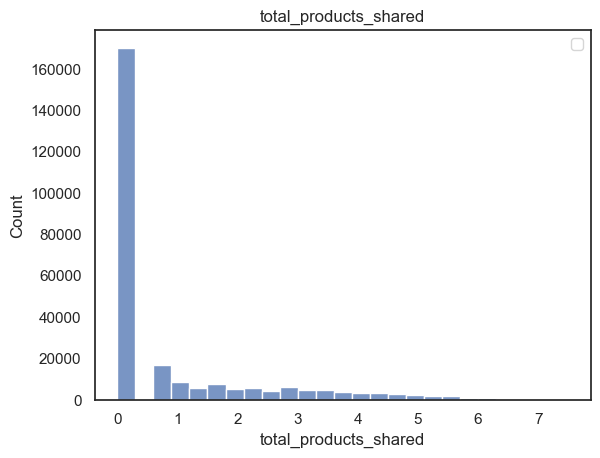

/Users/mauriciomoreno/opt/anaconda3/envs/capstone_shap/lib/python3.8/site-packages/pandas/core/internals/blocks.py:351: RuntimeWarning:

invalid value encountered in log

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


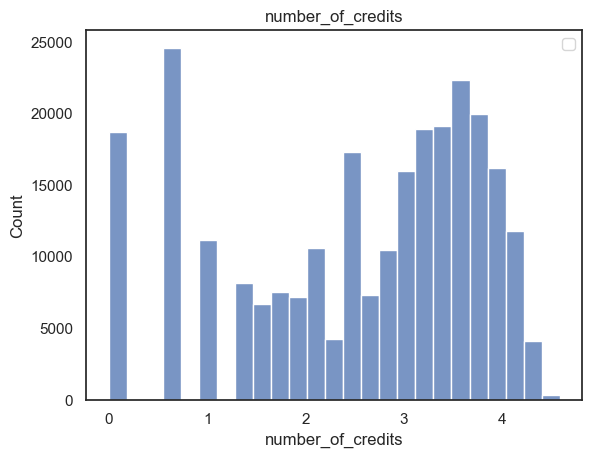

/Users/mauriciomoreno/opt/anaconda3/envs/capstone_shap/lib/python3.8/site-packages/pandas/core/internals/blocks.py:351: RuntimeWarning:

invalid value encountered in log

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


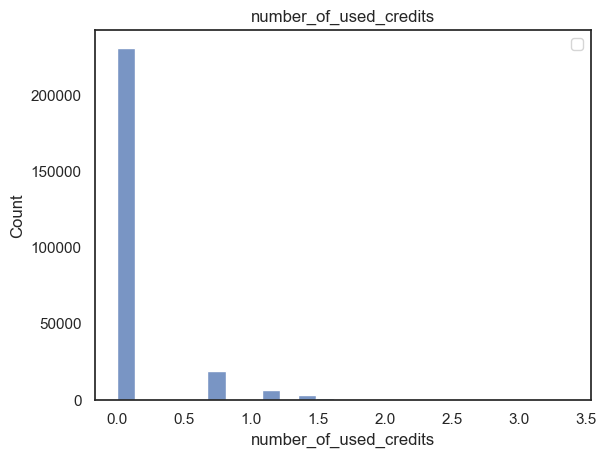

In [40]:
#Applying log transformation
log_cols = ["departments_sold", "avg_effective_delivery_days", "avg_effective_earnings", "number_of_products","number_of_categories", "total_products_shared", "number_of_credits", "number_of_used_credits"]

for c in log_cols:
    plt.figure()
    sns.histplot(data=np.log(df10 +1 ), x=c, bins=25)
    plt.xlabel(c)
    plt.title(c)
    plt.legend()
    plt.show()

### Splitting and Scaling:
- The split data uses DF10, random state 24, test size 20% and stratify
- Smote sampler was used
- Standard Scaler was also used

In [41]:
# splitting Data
X = df10.drop(columns="order_last_month")
y =df10["order_last_month"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=24)

In [42]:
#Smote sampler:
smote = SMOTE(random_state=24)


#Resample the data with Smote
X_train_sm, y_train_sm = smote.fit_resample(X_train, y_train)

In [43]:
# scale the sampled train data and the unsampled test data
#Standard Scaler on Smote
ss = StandardScaler()
ss_sm = ss.fit(X_train_sm)

#Rescaling the data
X_train_sm_ss = ss_sm.transform(X_train_sm)
X_test_ss_sm = ss_sm.transform(X_test)

In [45]:
#Saving the files
#pd.DataFrame(X_train_sm_ss, columns = df10.drop('Unnamed: 0',axis=1).columns).to_csv('../Data/elenas-it1-x_train_sm_ss.csv')
#pd.DataFrame(X_test_ss_sm, columns = df10.drop('Unnamed: 0',axis=1).columns).to_csv('../Data/elenas-it1-x_test_sm_ss.csv')
pd.DataFrame(y_train_sm, columns=["order_last_month"]).to_csv('../Data/elenas-it1-y_train_sm2.csv')
pd.DataFrame(y_test, columns=["order_last_month"]).to_csv('../Data/elenas-it1-y_test.csv')